## AFNI Deoblique

This notebook explores the implementation of *deobliquing* operations in AFNI, in order to be able to correctly manipulate transforms generated by the tool, and to produce transforms that can be correctly applied with AFNI.
Most of the preparation comes from the previous notebook.

This notebook is the test bed for resolving [issue #45](https://github.com/poldracklab/nitransforms/issues/45)

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [1]:
%load_ext autoreload
%matplotlib inline

import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import nibabel as nb
import nitransforms as nt
from nipype.interfaces.afni import Warp
from importlib import reload

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(os.getcwd())

/tmp/tmpqe3zvtnu


In [2]:
!wget https://nipy.org/nibabel/_downloads/c16214e490de2a223655d30f4ba78f15/someones_anatomy.nii.gz

--2021-11-11 16:04:24--  https://nipy.org/nibabel/_downloads/c16214e490de2a223655d30f4ba78f15/someones_anatomy.nii.gz
Resolving nipy.org (nipy.org)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to nipy.org (nipy.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191449 (187K) [application/gzip]
Saving to: ‘someones_anatomy.nii.gz’

someones_anatomy.ni 100%[===================>] 186.96K  --.-KB/s    in 0.03s   

2021-11-11 16:04:24 (5.71 MB/s) - ‘someones_anatomy.nii.gz’ saved [191449/191449]



### Load in the image
Let's first visualize the example image, and retain some copies of the original header and affine.

Center voxel: [28.  33.  27.5], shape: [57 67 56]
Center voxel coordinates: [0. 0. 0.]


<OrthoSlicer3D: (57, 67, 56)>

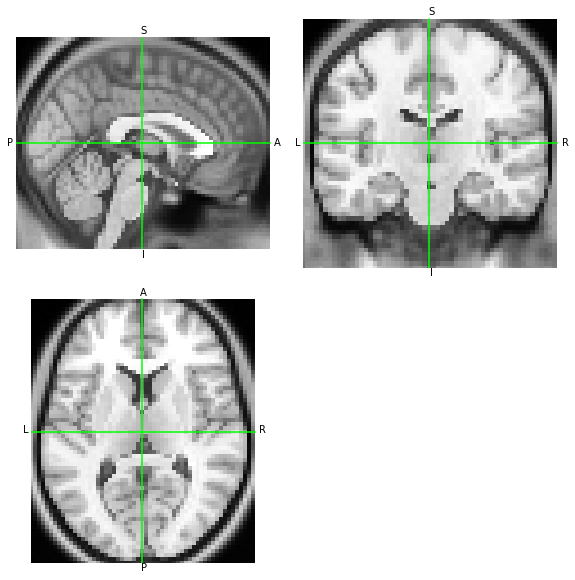

In [3]:
# Load the example
nii = nb.load('someones_anatomy.nii.gz')
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)

# Override affine (enable when anisotropic voxels are required)
# aff = np.diag((2, 3, 4, 1))

# Get center in voxel coords 
shape = np.array(data.shape[:3])
c_ijk = 0.5 * (shape - 1)
print(f"Center voxel: {c_ijk}, shape: {shape}")

center_xyz = aff[:3, :3] @ c_ijk

# Align RAS origin with data array center
# Disable for future tests more realistic
aff[:3, 3] = -center_xyz
center_xyz = nb.affines.apply_affine(aff, 0.5 * (np.array(data.shape[:3]) - 1))
print(f"Center voxel coordinates: {center_xyz}")
nii = nii.__class__(nii.dataobj, aff, nii.header)
nii.orthoview()

### Generating variants
Playing with the affine header and the data array ordering of axes and elements we generate several versions of the dataset with different orientations (LAS, LPS, oblique, LPS oblique).

In [4]:
# Create LAS version
las_aff = aff.copy()
las_aff[0, 0] *= -1.0
las_aff[0, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[0]

las = nb.Nifti1Image(np.flip(data, 0), las_aff, nii.header)
las.to_filename('someones_anatomy_LAS.nii.gz')

# Create LPS version
lps_aff = aff.copy()
lps_aff[0, 0] *= -1.0
lps_aff[1, 1] *= -1.0
lps_aff[:2, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[:2]

lps = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lps_aff, nii.header)
lps.to_filename('someones_anatomy_LPS.nii.gz')

# Create version not aligned to canonical
R = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001))
M = R.dot(nii.affine)
new_center_xyz = nb.affines.apply_affine(M, 0.5 * (np.array(data.shape[:3]) - 1))
M[:3, 3] += center_xyz - new_center_xyz
new_center_xyz = nb.affines.apply_affine(M, 0.5 * (np.array(data.shape[:3]) - 1))
assert np.all(new_center_xyz == center_xyz)
new = nb.Nifti1Image(data, M, hdr)
new.header.set_qform(M, 1)
new.header.set_sform(M, 1)
new.to_filename('someones_anatomy_rot.nii.gz')

# Create version not aligned to canonical (LPS)
lpsM = R.dot(lps.affine)
lpsnew = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lpsM, hdr)
lpsnew.header.set_qform(lpsM, 1)
lpsnew.header.set_sform(lpsM, 1)
lpsnew.to_filename('someones_anatomy_lpsrot.nii.gz')

### Run `3dWarp -deoblique`
Generate one example image after "deobliquing", to then see if we can generate equivalent composite transforms

In [5]:
#!3dWarp -deoblique -prefix deoblps.nii.gz someones_anatomy_lpsrot.nii.gz
Warp(in_file='someones_anatomy_rot.nii.gz', deoblique=True, verbose=True, out_file='deob.nii.gz').run()
deob = nb.load("deob.nii.gz")

211111-16:04:27,98 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.098637:++ 3dWarp: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
211111-16:04:27,101 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.098637:++ Authored by: RW Cox
211111-16:04:27,102 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.102139:** AFNI converts NIFTI_datatype=2 (UINT8) in file /tmp/tmpqe3zvtnu/someones_anatomy_rot.nii.gz to FLOAT32
211111-16:04:27,103 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.102139:     Warnings of this type will be muted for this session.
211111-16:04:27,103 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.102139:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
211111-16:04:27,104 nipype.interface INFO:
	 stderr 2021-11-11T16:04:27.102139:++ Using minimum spacing of 2.750000 mm for new grid spacing
211111-16:04:27,176 nipype.interface INFO:
	 stdout 2021-11-11T16:04:27.176279:# mat44 Obliquity Transformation ::
211111-16:04:27,177 nipype.interf

At this point, we can visualize the two images (remember to use world coordinates). The -o argument does not seem to work in my settings :(

In [6]:
print(f"mango {Path('someones_anatomy_rot.nii.gz').absolute()} -o {Path('deob.nii.gz').absolute()}")

mango /tmp/tmpqe3zvtnu/someones_anatomy_rot.nii.gz -o /tmp/tmpqe3zvtnu/deob.nii.gz


In [7]:
deob_shape = np.array(deob.shape)
print(f"Oblique RAS extent: {nb.affines.apply_affine(M, (0, 0, 0))} .. {nb.affines.apply_affine(M, shape - 1)}")
print(f"Orig.   RAS extent: {nb.affines.apply_affine(aff, (0, 0, 0))} .. {nb.affines.apply_affine(aff, shape - 1)}")
print(f"Deob.   RAS extent: {nb.affines.apply_affine(deob.affine, (0, 0, 0))} .. {nb.affines.apply_affine(deob.affine, deob_shape - 1)}")

print(f"Oblique RAS center: {nb.affines.apply_affine(M, 0.5 * (shape - 1))}")
print(f"Orig.   RAS center: {nb.affines.apply_affine(aff, 0.5 * (shape - 1))}")
print(f"Deob.   RAS center: {nb.affines.apply_affine(deob.affine, 0.5 * (deob_shape - 1))}")

Oblique RAS extent: [-76.98479805 -83.66920428 -83.40568476] .. [76.98479805 83.66920428 83.40568476]
Orig.   RAS extent: [-77.    -90.75  -75.625] .. [77.    90.75  75.625]
Deob.   RAS extent: [ 78.375       97.62501526 -83.875     ] .. [-78.375      -97.62498474  83.875     ]
Oblique RAS center: [0. 0. 0.]
Orig.   RAS center: [0. 0. 0.]
Deob.   RAS center: [0.00000000e+00 1.52587891e-05 0.00000000e+00]


### Generating AFNI's "deobliquing" matrices

Based on the image's information, we need to reconstruct AFNI's `WARPDRIVE_MATVEC_FOR_000000` affine, and then check that the results of applying such a matrix ends in the same outcome with AFNI and NiTransforms tools.

In [8]:
from nitransforms.io import afni

### Inspecting affines and headers
Generate a rotation affine to apply on the original affine of an image, and try to reconstruct the inverse of it as AFNI calculates it.

We use two new methods here. First `_afni_warpdrive()` runs our calculation of AFNI's WARPDRIVE affines (the rotation matrics we want to calculate)

In [9]:
ours_afni_R = afni._afni_warpdrive(new)
afni_R = afni._afni_header(deob)
afni_Rinv = afni._afni_header(deob, "WARPDRIVE_MATVEC_INV_000000")
print(np.isclose(afni_R, ours_afni_R))
print(afni_R)
print(ours_afni_R)

[-76.98445759 -75.91773778 -90.51847052]
[[ True  True  True False]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ 9.99998987e-01  1.08583097e-03  9.06073488e-04 -1.52124297e-02]
 [-9.99999233e-04  9.95952129e-01 -8.98794979e-02 -7.08078623e+00]
 [-9.99999815e-04  8.98784995e-02  9.95952129e-01 -7.78068304e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999000e-01  1.08583106e-03  9.06073535e-04 -1.52019521e-02]
 [-9.99999333e-04  9.95952145e-01 -8.98795002e-02 -7.08079572e+00]
 [-9.99999833e-04  8.98785043e-02  9.95952235e-01 -7.78068476e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [10]:
print(nb.affines.apply_affine(np.linalg.inv(deob.affine), (0, 0, 0)))
print(nb.affines.apply_affine(np.linalg.inv(afni.LPS.copy() @ new.affine), (0, 0, 0)))

print(np.round(afni_R @ deob.affine))
print(np.round((afni_R @ deob.affine) @ np.linalg.inv(new.affine)))

[28.5        35.50000555 30.5       ]
[28.  33.  27.5]
[[ -3.  -0.   0.  78.]
 [  0.  -3.  -0.  98.]
 [  0.  -0.   3. -83.]
 [  0.   0.   0.   1.]]
[[ -1.  -0.   0.   1.]
 [  0.  -1.  -0.   1.]
 [  0.  -0.   1. -15.]
 [  0.   0.   0.   1.]]


## Legacy code that could be useful, but I haven't checked

In [ ]:
print(R.T)
print(R.dot(nii.affine[:, 3]) - nii.affine[:, 3])
print(nii.affine[:, 3] - new.affine[:, 3])
print(new.affine[:, 3] - np.linalg.inv(R).T.dot(new.affine[:, 3]))

In [ ]:
print('\n'.join([str(row) for row in _afni_deoblique(new.affine, nii.affine)]))

In [ ]:
print(new.affine[:, 3] - nii.affine[:, 3])

print(nb.as_closest_canonical(new).affine)
print(new.affine)
print(new.header.get_best_affine())

In [ ]:
afni_dicom = np.diag([-1, -1, 1, 1]).dot(new.affine)
print(afni_dicom)

In [ ]:
deob = nb.load('deob.nii.gz')

print(nii.affine)
print(new.affine)
print(deob.affine)

In [ ]:
print(new.affine[:, -1])
print(R.dot(deob.affine[:, -1]))

In [ ]:
center = lps.affine[:3, :3].dot(np.array(lps.shape) - 0.5) * -0.5
origin = lps.affine[:3, -1]

print(center)
print(center - origin)

In [ ]:
center = lpsnew.affine[:3, :3].dot(np.array(lpsnew.shape) - 0.5) * -0.5
origin = lpsnew.affine[:3, -1]
print(center - origin)

In [ ]:
R_afni = deob.affine.dot(np.linalg.inv(lpsnew.affine))
print(R_afni)
print(np.linalg.inv(R))

In [ ]:
print(deob.header.extensions[0].get_content().decode())

### Reverse-engineering matrix compositions of oblique datasets
Calculating AFNI's affines based on the oblique image information

In [ ]:
R_afni = nb.load('deob.nii.gz').affine.dot(np.linalg.inv(new.affine))
print(R_afni)
print(np.linalg.inv(R))

In [ ]:
R_afni = new.affine.dot(np.linalg.inv(nb.load('deob.nii.gz').affine))
print(R_afni)
print(R)

### Visually test whether we correctly apply dual transforms with both tools
Load images generated with AFNI and with NiTransforms to check whether NiTransforms is operating as expected

In [ ]:
#!3dWarp -deoblique -prefix deob.nii.gz -NN someones_anatomy_rot.nii.gz
#!3dAllineate -base someones_anatomy.nii.gz -input someones_anatomy.nii.gz -master deob.nii.gz -1Dmatrix_apply for2.afni -prefix deob-for2.nii.gz -final NN
nb.load('deob.nii.gz').orthoview()
# nb.load('moved-for-T-inv.nii.gz').orthoview()
# nb.load('moved-inv-T-for.nii.gz').orthoview()
# nb.load('deob-for.nii.gz').orthoview()
nb.load('deob-for2.nii.gz').orthoview()
# nb.load('moved-affine-oblique-inv-T-for.nii.gz').orthoview()
# nb.load('moved-affine-oblique-inv-T-for-master.nii.gz').orthoview()

If both derivatives are resampled in the same space, the following figure should be almost (or fully) blank.

In [ ]:
deob = nb.load('deob.nii.gz')
nb.Nifti1Image(np.abs(deob.get_fdata() - nb.load('deob-for2.nii.gz').get_fdata()), deob.affine, deob.header).orthoview()